Populating the interactive namespace from numpy and matplotlib


/Users/vikram.natarajan/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['identity', 'random', 'seed', 'invert']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[('ShearX', 1.0, 4), ('Invert', 1.0, 3)]
[('Invert', 1.0, 4), ('Rotate', 1.0, 4)]
[('ShearX', 1.0, 9), ('TranslateY', 1.0, 3)]


Exception: hahahaha

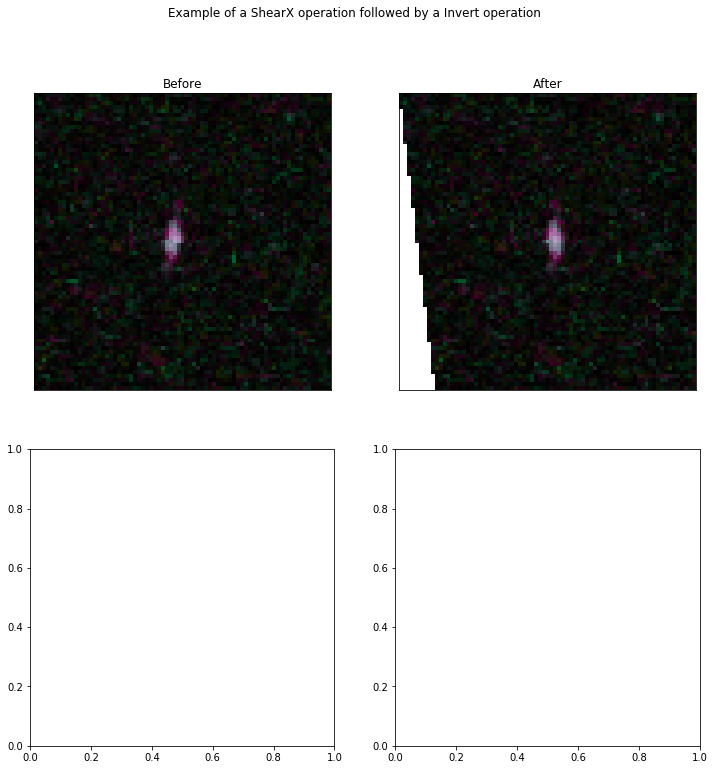

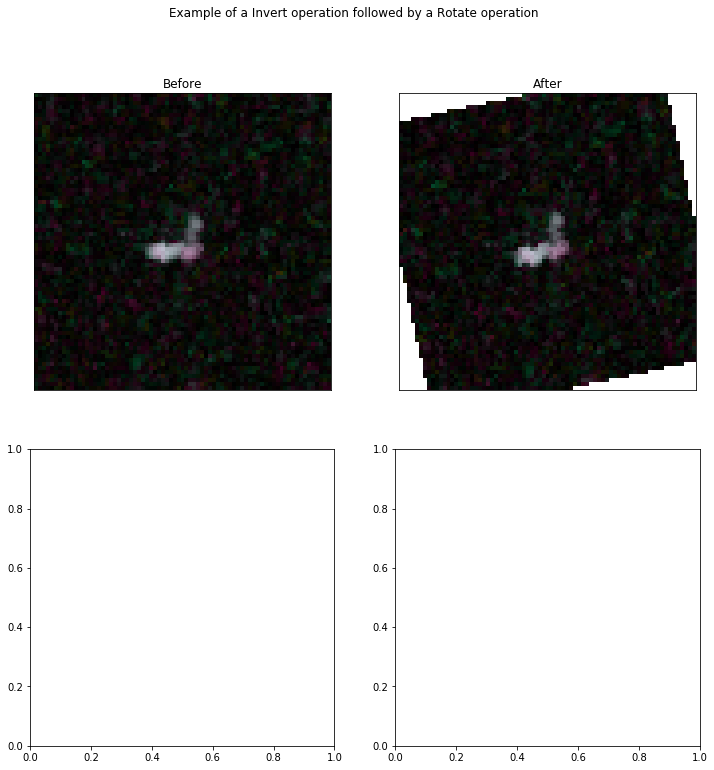

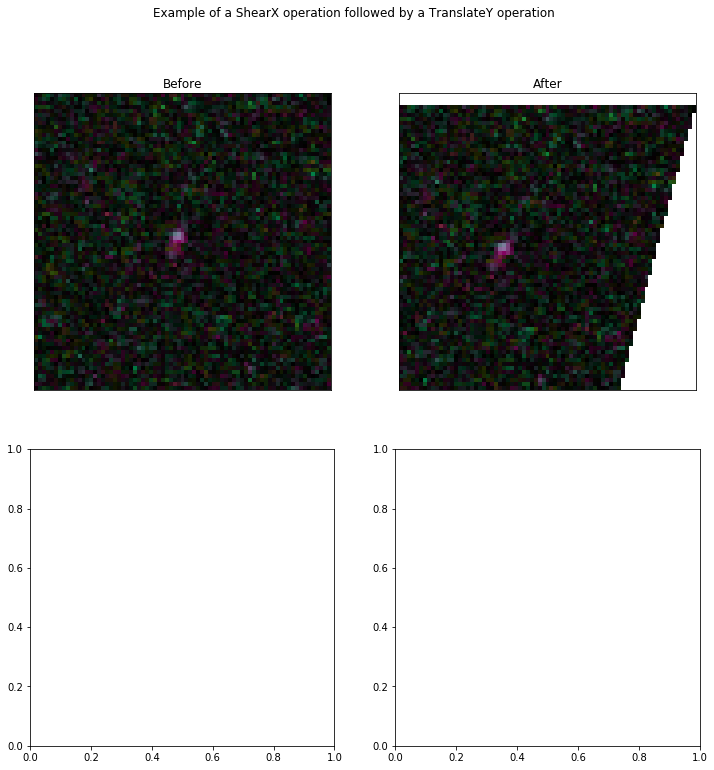

In [30]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 
seed = 1234
np.random.seed(seed) # The seed I used - pick your own or comment out for a random seed. A constant seed allows for better comparisons though

# Kfold
from sklearn.model_selection import StratifiedKFold

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from shvn_policies import good_policies
from augmentation_transforms import *
import sys

%pylab inline

my_policies = good_policies()

def get_scaled_imgs(df):
    """
    basic function for reshaping and rescaling data as images
    """
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        #imgs.append(np.dstack((a, b, c)))
        img = np.dstack((a, b, c))
        
        imgs.append(img)

    return np.array(imgs)    

def get_more_images_orig(imgs):
    """
    augmentation for more data
    """    


    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images


def get_more_images(imgs):
    """
    augmentation for more data
    """    


    more_images = []
    aa_imgs = []
    
#     policies = [
#     [('ShearX',0.9,4),('Invert',0.2,3)],
#     [('Invert',0.6,4),('Rotate',0.8,4)],
#     [('ShearX',0.7,9),('TranslateY',0.8,3)]
#     ]

    policies = [
    [('ShearX',1.0,4),('Invert',1.0,3)],
    [('Invert',1.0,4),('Rotate',1.0,4)],
    [('ShearX',1.0,9),('TranslateY',1.0,3)]
    ]
    
    
      
    for i, img in enumerate(imgs):
        if i >= len(policies):
            raise Exception("hahahaha")
        else:
            #epoch_policy = my_policies[np.random.choice(len(my_policies))]
            epoch_policy = policies[i]
            print (epoch_policy)
            final_img = apply_policy(epoch_policy, img)
            
            #print (img)
            img = np.abs(img)
            final_img = np.abs(final_img)

            fig, ax = plt.subplots(2, 2, figsize=(12, 12))
            ax[0, 0].imshow(img)
            ax[0, 1].imshow(final_img)
#             ax[0,0].set_axis_off()
#             ax[0,1].set_axis_off()
            ax[0,0].set_xticks([], [])
            ax[0,1].set_xticks([], [])
            ax[0,0].set_yticks([], [])
            ax[0,1].set_yticks([], [])
            ax[0,0].set_title("Before")
            ax[0,1].set_title("After")
            fig.suptitle("Example of a %s operation followed by a %s operation" % (epoch_policy[0][0],
                                                                                   epoch_policy[1][0]))
            aa_imgs.append(final_img)
      
    more_images = np.concatenate((imgs,aa_imgs))
    
    #import Image
    
#     im = Image.fromarray(final_img)
#     im.save('test.png')
    #print (final_img)
    
    print (epoch_policy)
    fig, ax = plt.subplots(figsize=(12, 12)) 
    ax.imshow(final_img)
    raise Exception("hahahaha")
    return more_images

## CNN Keras Model


def get_model():
    
    """
    Keras Sequential model

    """
    
    model=Sequential()
    
    # Conv block 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu' ))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
   
    # Conv block 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
   
    # Conv block 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
   
    #Conv block 4
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
   
    # Flatten before dense
    model.add(Flatten())

    #Dense 1
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))

    #Dense 2
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.0001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model



# Training Data
df_train = pd.read_json('train.json') # this is a dataframe


Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])
df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

Xtr_more = get_more_images(Xtrain) 
#Xtr_more = Xtrain 